# 1D Example

## Imports

In [1]:
# Imports 
import numpy as np
import scipy as sp
from time import time
import sys
sys.path.append("../")
import h2tools
from h2tools.mcbh import mcbh
from scipy.linalg import null_space
from problem_tools import set_up_problem as sup
from functions import test_funcs as tf
%matplotlib inline
import matplotlib.pyplot as plt
from copy import deepcopy, copy

## H2 matrix

In [2]:
# Main constants
c = 1e-3              # regularization parameter
diag_coef = 1 + c     # diagonal coefficient
sigma = 0.01          # kernel parameter
n = 1024              # matrix size
bs = 256              # block size limit for H2 matrix
tau = 1e-9            # H2 approximation accuracy
random_points = 0     # grid geometry parameter
ndim = 1              # problem dimensionality

In [3]:
# Set up the problem
np.random.seed(0)
func = tf.gauss_distance_h2t   # Gaussian kernel
close_r = 0.1                  # radius that defines close blocks
num_child_tree = 'hyper'       # number of children in the H2 tree
point_based_tree = 0           # H2 tree type
geom_type = 'cube'             # geometry: points equally spaced between 0 and 1     
symmetric_fun = 1              # H2 for symmetric function
t0 = time()

pr = sup.build_problem(geom_type=geom_type,
                      ndim = ndim,
                      n=n,
                      block_size=bs,
                      func=func,
                      point_based_tree=point_based_tree,
                      close_r=close_r,
                      num_child_tree=num_child_tree,
                      eps=tau,
                      random_points=random_points,
                      diag_coef = diag_coef,
                      sigma = sigma)
print(f'Problem build time: {time() - t0}, size: {pr.shape}.')

Problem build time: 0.2200770378112793, size: (1024, 1024).


In [4]:
# H2 matrix structure:
class Fmm(object):
    """
    Class representing an H2 matrix implementation.
    Includes methods for building and manipulating an H2 matrix.
    """
    def __init__(self, pr, basis_size, basis, transfer, dot_type='t', orig = 1):
        """
        Initializes the H2 matrix with given levels and block rank.
        """
        self.u = None
        self.orig = orig
        self.pr = pr
        self.n = copy(pr.shape[0])
        tree = self.pr.tree
        size = tree.level[-1]
        self.size = size
        self.basis = basis
        self.T = transfer
        self.dot_type = dot_type
        self.index_lvl = [None for i in range(size)]
        self.rks_r = basis_size.astype(int)
        self.rks_c = basis_size.astype(int)
        self.has_close_mat = 0
    def upd_index_lvl(self, ind):
        """
        Update the index level for a given node by combining basis indices of its children.
        """
        index_size = 0
        for ch in self.pr.tree.child[ind]:
            index_size += self.basis[ch].shape[0]
        self.index_lvl[ind] = np.zeros(index_size, dtype=int)
        tmp = 0
        for ch in self.pr.tree.child[ind]:
            self.index_lvl[ind][tmp:tmp+self.basis[ch].shape[0]] = self.basis[ch]
            tmp += self.basis[ch].shape[0]
    def dot(self, tmp):
        """
        Perform matrix-vector multiplication using the hierarchical H2 structure.
        """
        tmp_upd = copy(tmp)
        pr = self.pr
        tree = pr.tree
        level_count = len(tree.level) - 2
        tl = self.tail_lvl
        if self.dot_type == 't':
            ans = [np.zeros(pr.shape[0])] * (level_count - tl + 1)
            ans[0] = self.dot_cl(tmp_upd)
            for i in range(level_count-1, tl-1, -1):
                tmp_upd = self.dot_T( i, tmp_upd, 'up')
                ans[level_count-i] = self.dot_il(i, tmp_upd)
            for i in range(tl, level_count):
                ans[level_count-1-i] += self.dot_T(i, ans[level_count-i], 'down')
        else:
            ans = {}
            ans[0] = self.dot_cl(tmp_upd)
            for i in range(level_count-1, tl - 1, -1):
                tmp_upd = self.dot_T(i, tmp_upd, 'up')
                ans[level_count-i] = self.dot_il(i, tmp_upd)
            for i in range(tl, level_count):
                ans_far = self.dot_T(i, ans[level_count-i], 'down')
                ans[level_count-1-i] += ans_far
        return ans[0]
    def dot_cl(self, tmp):
        """
        Compute contributions from close interactions (near-field blocks).
        """
        pr = self.pr
        tree = self.pr.tree
        level_count = len(tree.level) - 2
        close = self.pr.close
        ans = np.zeros(self.n, dtype=self.pr.dtype)
        if self.orig:
            for i in range(level_count-1, tree.higest_leaf_lvl-1, -1):
                job = [j for j in
                       range(tree.level[i], tree.level[i+1])]
                for ind in job:
                    for i_cl in close[ind]:
                        if not tree.child[ind] and not tree.child[i_cl]:
                            col_ind = self.index_lvl[ind]
                            row_ind = self.index_lvl[i_cl]
                            if self.has_close_mat:
                                ans[col_ind] += self.close_mat[ind,i_cl].dot(tmp[row_ind])
                            else:
                                cb = self.pr.func(col_ind, row_ind)
                                ans[col_ind] += cb.dot(tmp[row_ind])
                        elif tree.child[ind] and not tree.child[i_cl]:
                            for ch_ind in tree.child[ind]:
                                col_ind = self.index_lvl[ch_ind]
                                row_ind = self.index_lvl[i_cl]
                                if self.has_close_mat:
                                    ans[col_ind] += self.close_mat[ch_ind,i_cl].dot(tmp[row_ind])
                                else:
                                    ans[col_ind] += self.pr.func(col_ind, row_ind).dot(tmp[row_ind])
                        elif not tree.child[ind] and tree.child[i_cl]:
                             for ch_cl in tree.child[i_cl]:
                                col_ind = self.index_lvl[ind]
                                row_ind = self.index_lvl[ch_cl]
                                if self.has_close_mat:
                                    ans[col_ind] += self.close_mat[ind,ch_cl].dot(tmp[row_ind])
                                else:
                                    ans[col_ind] += self.pr.func(col_ind, row_ind).dot(tmp[row_ind])
        else:
            i = level_count - 1  
            job = [j for j in range(tree.level[i], tree.level[i+1])]
            tmp_vec_i = {}
            n_sm = 0
            ctr = 0
            for ind in job:
                n_sm += self.u[ind].shape[0]
                tmp_vec_i[ind] = copy(tmp[ctr:ctr+self.u[ind].shape[0]])
                ctr = ctr + self.u[ind].shape[0]

            atr = 0
            for ind in job:
                for i_cl in close[ind]:
                    ans[atr:atr+self.u[ind].shape[0]] += self.close_mat[ind,i_cl].dot(tmp_vec_i[i_cl])
                atr = atr + self.u[ind].shape[0]
        return ans
    def dot_il(self, i, tmp):
        """
        Compute contributions from far interactions (interpolative far-field blocks).
        """
        il = self.pr.far
        job = [j for j in range(self.pr.tree.level[i], self.pr.tree.level[i+1])]
        if self.dot_type == 't':
            ans = np.zeros(self.n,dtype=self.pr.dtype)
            for ind in job:
                for i_il in il[ind]:
                    col_ind = self.basis[ind]
                    row_ind = self.basis[i_il]
                    if self.dot_type == 't':
                        ans[col_ind] += self.pr.func(col_ind, row_ind).dot(tmp[row_ind])
                    else:
                        ans[col_ind] += self.il_mat[ind,i_il].dot(tmp[row_ind])
        else:
            tmp_vec_i = {}
            n_sm = 0
            ctr = 0
            for ind in job:
                n_sm += self.rks_r[ind]
                tmp_vec_i[ind] = tmp[ctr:ctr+self.rks_c[ind]]
                ctr = ctr+self.rks_c[ind]
                
            ans = np.zeros(n_sm, dtype=self.pr.dtype)   
            atr = 0
            for ind in job:
                for i_il in il[ind]:
                    ans[atr:atr+self.rks_r[ind]] += self.il_mat[ind, i_il]@tmp_vec_i[i_il]
                atr = atr + self.rks_r[ind]
        return ans
    def dot_T(self, i, tmp, prod_type):
        """
        Apply the transfer matrices for upward or downward traversal in the H2 tree.
        """
        level_count = len(self.pr.tree.level) - 2
        tree = self.pr.tree
        job = [j for j in
               range(self.pr.tree.level[i], self.pr.tree.level[i+1])]
        if self.dot_type == 't':
            for ind in job:
                if prod_type == 'up':
                    T = self.T[ind].T
                    tmp[self.basis[ind]] = T.dot(tmp[self.index_lvl[ind]])
                else:
                    T = self.T[ind]
                    tmp[self.index_lvl[ind]] = T.dot(tmp[self.basis[ind]])
        else:
            if prod_type == 'up':
                sm_n = 0
                for ind in job:
                    sm_n += self.rks_r[ind]
                ans = np.zeros(sm_n, dtype=self.pr.dtype)  
                atr = 0
                ctr = 0
                for ind in job:
                    if i == level_count - 1 and self.orig:
                        ans[atr:atr+self.u[ind].shape[1]] = self.u[ind].T.dot(tmp[tree.index[ind]])
                    else:
                        ans[atr:atr+self.u[ind].shape[1]] = self.u[ind].T.dot(tmp[ctr:ctr+self.u[ind].shape[0]])
                    ctr = ctr + self.u[ind].shape[0]
                    atr = atr + self.u[ind].shape[1]
            else:
                ctr = 0
                if i == level_count - 1 and self.orig:
                    ans = np.zeros(self.n, dtype=self.pr.dtype)
                    for ind in job:
                        ans[tree.index[ind]] = self.u[ind].dot(tmp[ctr:ctr+self.rks_r[ind]])
                        ctr = ctr + self.rks_r[ind]
                else:
                    sm_n = 0
                    for ind in job:
                        sm_n += self.u[ind].shape[0]
                    ans = np.zeros(sm_n, dtype=self.pr.dtype)
                    atr = 0
                    for ind in job:  
                        ans[atr:atr+self.u[ind].shape[0]] = self.u[ind].dot(tmp[ctr:ctr+self.rks_r[ind]])
                        ctr = ctr + self.rks_r[ind]
                        atr = atr + self.u[ind].shape[0]
            tmp = copy(ans)
        return tmp
    def dot_T_abasis(self, i, tmp, prod_type):
        """
        Apply transfer matrices while using the null space of the basis for upward/downward traversal.
        """
        job = [j for j in
               range(self.pr.tree.level[i], self.pr.tree.level[i+1])]
        if self.dot_type == 't':
            raise NameError('For this function, dot_type = u is required!')
        else:
            if prod_type == 'up':
                sm_n = 0
                for ind in job:
                    sm_n += self.index_lvl[ind].shape[0] - self.rks_r[ind]
                ans = np.zeros(sm_n, dtype=self.pr.dtype)  
                atr = 0
                ctr = 0
                for ind in job:
                    u_ns =  null_space(fmm.u[ind].T)
                    if i == level_count - 1 and self.orig:
                        ans[atr:atr+u_ns.shape[1]] = u_ns.T.dot(tmp[tree.index[ind]])
                    else:
                        ans[atr:atr+u_ns.shape[1]] = u_ns.T.dot(tmp[ctr:ctr+u_ns.shape[0]])
                    ctr = ctr + u_ns.shape[0]
                    atr = atr + u_ns.shape[1]
            else:
                ctr = 0
                if i == level_count - 1 and self.orig:
                    ans = np.zeros(self.n, dtype=self.pr.dtype)
                    for ind in job:
                        ns_size = self.index_lvl[ind].shape[0] - self.rks_r[ind]
                        u_ns =  null_space(fmm.u[ind].T)
                        ans[tree.index[ind]] = u_ns.dot(tmp[ctr:ctr+ns_size])
                        ctr = ctr + ns_size
                else:
                    sm_n = 0
                    for ind in job:
                        sm_n += self.u[ind].shape[0]
                    ans = np.zeros(sm_n, dtype=self.pr.dtype)
                    atr = 0
                    for ind in job: 
                        ns_size = self.index_lvl[ind].shape[0] - self.rks_r[ind]
                        u_ns =  null_space(fmm.u[ind].T)
                        ans[atr:atr+u_ns.shape[0]] = u_ns.dot(tmp[ctr:ctr+ns_size])
                        ctr = ctr + ns_size
                        atr = atr + self.u[ind].shape[0]
            tmp = copy(ans)
        return tmp
    def make_uv(self):
        """
        Construct U and V bases for the H2 matrix using SVD compression at each level.
        """
        tree = self.pr.tree
        tl = self.tail_lvl
        il = self.pr.far
        level_count = len(tree.level) - 2
        size = self.size
        self.u = [None for i in range(size)]
        self.il_mat = {}
        for i in range(level_count-1, tl-1, -1):
            job = [j for j in range(tree.level[i], tree.level[i+1])]
            pr_1 = -2
            print(f'LvL: {i}')
            for ind in job:
                pr_ind = tree.parent[ind]
                if pr_1 != pr_ind:
                    count = 0
                pr_1 = copy(pr_ind)
                if len(tree.child[ind]) == 0:
                    sm_T = self.T[ind]
                else:
                    sm_T = copy(self.u[ind])
                u, s, v = np.linalg.svd(sm_T,full_matrices=0)
                self.u[ind] = copy(u)

                if not(self.T[pr_ind] is None):
                    if self.u[pr_ind] is None:
                        self.u[pr_ind] = copy(self.T[pr_ind])
                    self.u[pr_ind][count:count+v.shape[0],:] = np.diag(s) @ v @ self.u[pr_ind][count:count+v.shape[0],:]
                count = count + v.shape[0]
                for i_il in il[ind]:
                    if (ind, i_il) in self.il_mat:
                        self.il_mat[ind,i_il] = np.diag(s) @ v @ self.il_mat[ind,i_il]
                    else:
                        col_ind = self.basis[ind]
                        row_ind = self.basis[i_il]
                        bl = self.pr.func(col_ind, row_ind)
                        self.il_mat[ind,i_il] = np.diag(s) @ v @ bl

                    if (i_il, ind) in self.il_mat:
                        self.il_mat[i_il, ind] =  self.il_mat[i_il, ind] @ v.T @ np.diag(s) 
                    else:
                        col_ind = self.basis[i_il]
                        row_ind = self.basis[ind]
                        bl = self.pr.func(col_ind, row_ind)
                        self.il_mat[i_il, ind] = bl @ v.T @ np.diag(s) 
    def shrink_leaf_lvl(self):
        """
        Shrink the leaf-level blocks of the H2 matrix.
        """
        self.orig = 0
        if self.flvl == 1:
            print("Warning! Last lvl should poduce dense tilda!!!")
        tree = self.pr.tree
        close = self.pr.close
        il = self.pr.far
        level_count = len(tree.level) - 2
        i = level_count - 2
        job = [j for j in
                   range(tree.level[i], tree.level[i+1])]
        self.n = 0
        for rind in job:
            if tree.child[rind]:
                r_size = 0
                for rch in tree.child[rind]:
                    r_size += self.rks_r[rch]
            else:
                r_size = tree.index[rind].shape[0]
            self.n += r_size
            
            for cind in close[rind]:
                if tree.child[cind]:
                    c_size = 0    
                    for cch in tree.child[cind]:
                        c_size += self.rks_c[cch]  
                    cl_bl = np.zeros((r_size, c_size),dtype=self.pr.dtype)
                    if tree.child[rind]:
                        rtmp = 0
                        for rch in tree.child[rind]:
                            ctmp = 0
                            for cch in tree.child[cind]:
                                if rch in close[cch]:
                                    bl = self.u[rch].T @ self.close_mat[rch,cch] @ self.u[cch]
                                    cl_bl[rtmp : rtmp + self.rks_r[rch], ctmp : ctmp + self.rks_c[cch]] = bl
                                elif rch in il[cch]:
                                    cl_bl[rtmp : rtmp + self.rks_r[rch], ctmp : ctmp + self.rks_c[cch]] = self.il_mat[rch,cch]
                                else:
                                    print ("Bug! Wrong close!")
                                ctmp =  ctmp + self.rks_c[cch]
                            rtmp = rtmp + self.rks_r[rch]
                        self.close_mat[rind, cind] = cl_bl
                    else:
                        ctmp = 0
                        for cch in tree.child[cind]:
                            bl = self.close_mat[rind,cch] @ self.u[cch]
                            cl_bl[:, ctmp : ctmp + self.rks_c[cch]] = bl
                            ctmp =  ctmp + self.rks_c[cch]
                    self.close_mat[rind, cind] = cl_bl
                else:
                    if tree.child[rind]:
                        c_size = tree.index[cind].shape[0]
                        cl_bl = np.zeros((r_size, c_size))
                        rtmp = 0
                        for rch in tree.child[rind]:
                            bl = self.u[rch].T @ self.close_mat[rch,cind]
                            cl_bl[rtmp : rtmp + self.rks_r[rch]] = bl
                            rtmp =  rtmp + self.rks_r[rch]
                        self.close_mat[rind, cind] = cl_bl                    
        i = level_count - 1
        job = [j for j in range(tree.level[i], tree.level[i+1])]
        for rind in job:
            if self.orig:
                for cind in job:
                    del self.il_mat[rind, cind]
            else: 
                for cind in il[rind]:
                    del self.il_mat[rind, cind]
            for cind in close[rind]:
                del self.close_mat[rind, cind]
        self.flvl = self.flvl - 1                    
        tree.level[-2] = tree.level[-3]
        tree.level = tree.level[:-1]
        size = tree.level[-1]
        self.size = size
        self.shape = (self.n, self.n)
        self.u = self.u[:tree.level[-1]]
    def add_close_mat(self):
        """
        Precompute and store the close interaction matrices for efficiency.
        """
        if self.has_close_mat == 1:
            print ("fmm.has_close_mat = 1! Looks like you already have close_mat")
            return 0
        self.has_close_mat = 1
        self.close_mat = {}
        pr = self.pr
        tree = pr.tree
        level_count = len(tree.level) - 2
        close = self.pr.close
        ans = np.zeros(self.n, dtype=self.pr.dtype)
        for i in range(level_count-1, tree.higest_leaf_lvl-1, -1):
            job = [j for j in
                   range(tree.level[i], tree.level[i+1])]
            for ind in job:
                for i_cl in close[ind]:
                    if not tree.child[ind] and not tree.child[i_cl]:
                        col_ind = self.index_lvl[ind]
                        row_ind = self.index_lvl[i_cl]
                        self.close_mat[ind,i_cl] = self.pr.func(col_ind, row_ind)
                    elif tree.child[ind] and not tree.child[i_cl]:
                        for ch_ind in tree.child[ind]:
                            col_ind = self.index_lvl[ch_ind]
                            row_ind = self.index_lvl[i_cl]
                            self.close_mat[ch_ind,i_cl] = self.pr.func(col_ind, row_ind)
                    elif not tree.child[ind] and tree.child[i_cl]:
                         for ch_cl in tree.child[i_cl]:
                            col_ind = self.index_lvl[ind]
                            row_ind = self.index_lvl[ch_cl]
                            self.close_mat[ind,ch_cl] = self.pr.func(col_ind, row_ind)
    def solve_block_diag(self, rhs):
        """
        Solve the block diagonal system at the leaf level of the H2 matrix.
        """
        pr = self.pr
        tree = pr.tree
        leaf_lvl = len(tree.level) - 3
        ans = np.zeros(self.n, dtype=self.pr.dtype)
        job = [j for j in range(tree.level[leaf_lvl], tree.level[leaf_lvl+1])]
        if self.orig:
            for ind in job:
                row_ind = self.index_lvl[ind]
                col_ind = self.index_lvl[ind]
                if self.has_close_mat:
                    ans[col_ind] = np.linalg.solve(self.close_mat[ind,ind],rhs[row_ind])
                else:
                    ans[col_ind] = np.linalg.solve(self.pr.func(col_ind, row_ind),rhs[row_ind])
        else:
            ctr_r = 0
            ctr_c = 0
            for ind in job:
                db = self.close_mat[ind,ind]
                ans[ctr_c:ctr_c+db.shape[1]] = np.linalg.solve(db,rhs[ctr_r:ctr_r+db.shape[0]])
                ctr_r = ctr_r + db.shape[0]
                ctr_c = ctr_c + db.shape[1]
        return ans
    def dot_block_diag(self, vec):
        """
        Perform a matrix-vector product for the block diagonal system at the leaf level.
        """
        pr = self.pr
        tree = pr.tree
        leaf_lvl = len(tree.level) - 3
        ans = np.zeros(self.n, dtype=self.pr.dtype)
        job = [j for j in range(tree.level[leaf_lvl], tree.level[leaf_lvl+1])]
        if self.orig:
            for ind in job:
                row_ind = self.index_lvl[ind]
                col_ind = self.index_lvl[ind]
                if self.has_close_mat:
                    ans[row_ind] = self.close_mat[ind,ind].dot(vec[col_ind])
                else:
                    ans[row_ind] = self.pr.func(col_ind, row_ind).dot(vec[col_ind])
        else:
            ctr_r = 0
            ctr_c = 0
            for ind in job:
                db = self.close_mat[ind,ind]
                ans[ctr_r:ctr_r+db.shape[0]] = db.dot(vec[ctr_c:ctr_c+db.shape[1]])
                ctr_r = ctr_r + db.shape[0]
                ctr_c = ctr_c + db.shape[1]
        return ans
def build_fmm_mcbh(pr, tau=1e-4, iters=1, dot_type='t'):
    """
    Function builds H2 matrix in h2tools format and transforms it into local format
    """
    pr.symmetric = 1
    basis_size, _, transfer, _, _, _, _, _, basis, _, _ = mcbh(pr, tau=tau, iters=iters, onfly=0, verbose=0)
    fmm = Fmm(pr, basis_size, basis, transfer)
    tree = pr.tree
    level_count = len(tree.level) - 2
    ind_l = []
    fmm.tail_lvl = pr.tail_lvl

    for i in range(level_count-1, fmm.tail_lvl-1, -1):
        job = [j for j in
               range(tree.level[i], tree.level[i+1])]
        for ind in job:
            if tree.child[ind]:
                fmm.upd_index_lvl(ind)
            else:
                fmm.index_lvl[ind] = fmm.pr.tree.index[ind]
    return fmm                            

In [5]:
# Build H2 matrix
fmm = build_fmm_mcbh(pr, tau=tau, iters=1)

In [6]:
# H2 matrix test
mat = pr.func(np.arange(pr.shape[0]),np.arange(pr.shape[0]))
test_ans = mat.dot(np.ones(fmm.n,dtype=pr.dtype))
my_ans = fmm.dot(np.ones(fmm.n,dtype=pr.dtype))
print(f"H2 matrix accuracy: {np.linalg.norm(test_ans - my_ans)/ np.linalg.norm(my_ans):.2e}")

H2 matrix accuracy: 7.07e-09


## H2 - MG

In [7]:
# Functions to build matrices A, A_2, ..., A_l
def make_dense_tilda(self):
    """
    Constructs dense matrix A_l.
    """
    cl = self.pr.close
    il = self.pr.far
    tl = self.tail_lvl
    tree = self.pr.tree
    level_count = len(tree.level) - 2
    llvl = level_count - 1
    job = [j for j in range(tree.level[llvl], tree.level[llvl+1])]
    n = 0
    m = 0
    for i in job:
        n += int(self.rks_r[i])
    for i in job:
        m += int(self.rks_c[i])
    if n != m:
        print("Warning! Tilda is reqtangular!") 
    a_tild = np.zeros((n,m), dtype=self.pr.dtype)
    dense_far = {}
    for i_lvl in range(0, llvl):
#         print (i_lvl)
        job = [j for j in range(tree.level[i_lvl], tree.level[i_lvl+1])]
        for i in job:    
            for j in job:
                if j in il[i]:
                    par_bl = self.u[i] @ self.il_mat[i, j] @ self.u[j].T
                elif not j in cl[i]:
                    par_bl = self.u[i] @ dense_far[i, j] @ self.u[j].T
                else:
                    continue
                ptr_i = 0
                for i_ch in tree.child[i]:
                    ptr_j = 0
                    for j_ch in tree.child[j]:
                        dense_far[i_ch, j_ch] = par_bl[ptr_i:ptr_i+self.rks_r[i_ch],ptr_j:ptr_j+self.rks_c[j_ch]]
                        ptr_j = ptr_j+self.rks_c[j_ch]
                    ptr_i = ptr_i+self.rks_r[i_ch]
#     print (np.linalg.norm(dense_far[21, 37]))            
    job = [j for j in range(tree.level[llvl], tree.level[llvl+1])]
    ptr_r = 0 
    for i in job:
        ptr_c = 0
        for j in job:
            if j in cl[i]:
#                 print (i,j)
                row_ind = np.arange(ptr_r, ptr_r + self.rks_r[i])
                col_ind = np.arange(ptr_c, ptr_c + self.rks_c[j])
                big_cl = self.close_mat[i,j]
#                 print(type(row_ind),type(row_ind[0]),type(i),type(j))
                a_tild[np.ix_(row_ind, col_ind)] = self.u[i].T @ big_cl @ self.u[j]
            elif j in il[i]:
#                 if i == 21:# and j == 25:
# #                     print(i,j, ptr_r,ptr_c)
#                     print(j)
                row_ind = np.arange(ptr_r, ptr_r + self.rks_r[i])
                col_ind = np.arange(ptr_c, ptr_c + self.rks_c[j])
                a_tild[np.ix_(row_ind, col_ind)] = self.il_mat[i, j]
            else:
#                 if i == 21:
#                     print(ptr_c)
                row_ind = np.arange(ptr_r, ptr_r + self.rks_r[i])
                col_ind = np.arange(ptr_c, ptr_c + self.rks_c[j])
                a_tild[np.ix_(row_ind, col_ind)] = dense_far[i, j]
            ptr_c = ptr_c + self.rks_c[j]
        ptr_r = ptr_r + self.rks_r[i]
    return a_tild           
def make_tilda_list(fmm_mat, flvl = 1):
    """
    Constructs H2 matrices A_2, ..., A_{l-1}
    """
    tree = fmm_mat.pr.tree
    tl = fmm_mat.tail_lvl
    level_count = len(tree.level) - 2
    if level_count - 1 > tree.higest_leaf_lvl:
        print ("Sorry! Incomplite leaf level is under construction!")
        return (0)
    if level_count - flvl > tree.higest_leaf_lvl:
        print ("Error! you trying to make incomleate leaf level tilda matrix")
        return (0)
    if level_count - tl < flvl:
        print ("Error! you trying to make tilda of empty lvl")
        return (0)
    t0 = time()
    if fmm_mat.has_close_mat == 0:
        fmm_mat.add_close_mat()  
    print(f'Time to add close matrix: {time()-t0} s')
    t1 = time() 
    if fmm_mat.u is None:
        fmm_mat.make_uv()
    print(f'Time to make U basis: {time()-t1} s')
    fmm_mat.dot_type = 'u'
    tilda_list = {}
    fmm_mat.flvl = flvl
    fmm_tmp = deepcopy(fmm_mat)
    print (f"Lvl {level_count}, copy h2")
    tilda_list[level_count] = deepcopy(fmm_mat)
    for i in range(level_count-1, level_count - flvl - 1, -1):
        if i == level_count - flvl:
            print (f"Lvl {i}, do dense")
            fmm_tmp = make_dense_tilda(fmm_tmp)
        else:
            print (f"Lvl {i}, do h2")
            fmm_tmp.shrink_leaf_lvl()
        tilda_list[i] = deepcopy(fmm_tmp)
    return tilda_list

In [8]:
# CG solver
def cg_my(A, b, x0=None, p = None, r1=None, n_iter=100, verbose=0, tol = 1e-10, x_true = None, t_cg = None):
    """
    Implementation of the CG method
    """
    n = A.n
    m = A.n
    max_it = -1
    
    res = np.zeros(n_iter + 1, dtype = fmm.pr.dtype)
    anorm = np.zeros(n_iter + 1, dtype=fmm.pr.dtype)
#     print (np.linalg.norn(b))
    if n != m:
        raise NameError('Matrix should be square')
    
    if x0 is None:
        x0 = np.zeros(n, dtype=fmm.pr.dtype)
    r = b - A.dot(x0)
    if (p is None) and (r1 is None):
        p = r.copy()
        r1 = np.dot(r, r)
    elif (p is None) or (r1 is None):
        print ("Error! p and r1 should be None/ not None at the same time!")
    r_k_norm = np.dot(r, r)
    res[0] = np.sqrt(np.dot(r, r))/np.linalg.norm(b)
    if not x_true is None:
        ek = x_true - x0
        anorm[0] = np.sqrt(ek.dot(A.dot(ek)))
        if not t_cg is None:
                t_cg.append(time())
            
    if verbose:
             print(f"iter:{0}, a-norm: {anorm[0]:.8f}, xk: {np.linalg.norm(x0):.16f}, p:{np.linalg.norm(p)} "
                   f"residual: {res[0]:.16f}", end='\n')
    for i in range(n_iter):
        Ap = A.dot(p)
        alpha = r_k_norm / np.dot(p, Ap)
        x0 += alpha * p
        r -= alpha * Ap
        r_kplus1_norm = np.dot(r, r)
        beta = r_kplus1_norm / r_k_norm
        r_k_norm = r_kplus1_norm
        if not x_true is None:
            ek = x_true - x0
            ttt = ek.dot(A.dot(ek))
#             print(ttt)
            anorm[i+1] = np.sqrt(ttt)
            if not t_cg is None:
                t_cg.append(time())
        p = beta * p + r
        res[i+1] = np.sqrt(np.dot(r, r))/np.linalg.norm(b)
        if verbose and not x_true is None:
            print(f"iter:{i+1},a-norm: {anorm[i+1]:.8f}, xk: {np.linalg.norm(x0):.16f}, p:{np.linalg.norm(p)}"
                  f"residual: {res[i+1]:.16f}", end='\n')
        if res[i] < tol:
            max_it = i 
            break         
    if max_it == -1:
        max_it = n_iter
    if not x_true is None:
        return (x0, p, r1), (res[:max_it+2], anorm[:max_it+2])
    else:
        return x0

In [9]:
# H2-MG algorithm
def h2_mg(b, xk=None, tilda_list=None, lc = 0, mg_type = 'no_mg', 
           x_true = None, n_iter = 10, tol = 1e-10, n_v_iter = 0, 
           verbose=[0,0,0], flvl=None, n_in_iter = None, t_cg = None, 
           method = None, err_in_basis=0): 
    """
    Implementation of the H2-MG algorithm.
    """
    if n_in_iter is None:
        n_in_iter = n_iter
    lag = 1
    filenames = []
    itvl = (1e-10, 1e2)
    ue_list = []
    tue_list = []
    total_iter = ((n_iter+1)*2+1)*n_v_iter
    max_it = -1
    res = np.zeros(total_iter, dtype=fmm.pr.dtype)
    anorm = np.zeros(total_iter, dtype=fmm.pr.dtype)
    p = None
    r1 = None
    if not t_cg is None:
        t_cg = []
    t0 = time()
    A = tilda_list[lc]
    tree = A.pr.tree
    ctr = 0
    if xk is None:
        ek = - x_true
    else:
        ek = xk - x_true
    tot_ip = 0
    if verbose[2]:
        filename, ctr, ue, tue  = plot_for_gif(fmm, ek, err_in_basis, ctr, np.linalg.norm(b))
        ue_list.append(ue)
        tue_list.append(tue)
        filenames.append(filename)
    for i in range(n_v_iter):
        if verbose[0]:
            print(f'V-cycle # {i}')

        (xk, p, r1), res_up = iter_solver(A, b, x0 = xk, p=p, r1=r1, x_true=x_true, 
                       verbose=verbose[1], n_iter=n_iter, tol=tol, t_cg = t_cg, method = method)
        ek = xk - x_true
        if verbose[2]:
            filename, ctr, ue, tue = plot_for_gif(fmm, ek, err_in_basis, ctr, np.linalg.norm(b))
            ue_list.append(ue)
            tue_list.append(tue)
            filenames.append(filename)
        if res_up[0].shape[0] != res_up[1].shape[0]:
            print('Warning! Size of result does not match size of anorm')
        res[tot_ip:tot_ip+res_up[0].shape[0]] = res_up[0]
        anorm[tot_ip:tot_ip+res_up[0].shape[0]] = res_up[1]
        tot_ip = tot_ip + res_up[0].shape[0]
        if verbose[1]:
            print(f'anorm after first cg: {res_up[1]/np.linalg.norm(b)}')
            print(f'res after first cg: {res_up[0]}')
            print(f'norm of ek:{np.linalg.norm(ek)}')
        if verbose[0]:
            print(f'after first cg anomn: {(res_up[1]/np.linalg.norm(b))[-1]}, ||ek||: {np.linalg.norm(ek)}')
        if mg_type == 'no_mg':
            res[tot_ip] = res[tot_ip-1]
            ek = xk - x_true
            anorm[tot_ip] = np.sqrt(np.dot(ek, A.dot(ek)))
            tot_ip += 1
            if not t_cg is None:
                t_cg.append(time())
            (xk, p, r1), res_down = iter_solver(A, b,  x0=xk, p=p, r1=r1, x_true = x_true, 
                             verbose=verbose[1], n_iter=n_iter, tol=tol, t_cg = t_cg,method = method)
            if verbose[2]:
                filename, ctr, ue, tue = plot_for_gif(fmm, ek, err_in_basis, ctr, np.linalg.norm(b))
                ue_list.append(ue)
                tue_list.append(tue)
                filenames.append(filename)
            
            if res_down[0].shape[0] != res_down[1].shape[0]:
                print('Warning! size res != size anorm')
            res[tot_ip:tot_ip+res_down[0].shape[0]] = res_down[0]
            anorm[tot_ip:tot_ip+res_down[0].shape[0]] = res_down[1]
            tot_ip = tot_ip + res_down[0].shape[0]
            if verbose[1]:
                print(f'anorm after second cg: {res_down[1]/np.linalg.norm(b)}')
                print(f'res after second cg: {res_down[0]}')
                print(np.linalg.norm(ek))
            if verbose[0]:
                ek = xk - x_true
                print(f'after second cg anomn: {(res_down[1]/np.linalg.norm(b))[-1]}, ||ek||: {np.linalg.norm(ek)}')
        elif mg_type == 'u':
            p = None
            r1 = None
            flvl = A.flvl
            level_count = len(tree.level) - 2
            xk_old = xk.copy()
            r = b - A.dot(xk)
            xk_dict = {}
            r_dict = {}
            
            # go up
            for lvl in range(level_count-1, level_count - flvl, -1):
                r = A.dot_T(lvl, r, 'up')
                r_dict[lvl] = copy(r)
                xk_dict[lvl] = iter_solver(tilda_list[lvl], r, n_iter=n_in_iter, tol=tol, method = method)
                r = r - tilda_list[lvl].dot(xk_dict[lvl])
            
            # top
            r = A.dot_T(level_count - flvl, r, 'up')
            e = np.linalg.solve(tilda_list[level_count - flvl], r)
            e = A.dot_T(level_count - flvl, e, 'down')
            
            # go down
            for lvl in range(level_count - flvl + 1, level_count):
                xk_dict[lvl] += e
                e = iter_solver(tilda_list[lvl], r_dict[lvl], x0 = xk_dict[lvl], n_iter=n_in_iter, tol=tol,method = method)
                e = A.dot_T(lvl, e, 'down')
            
            xk = xk_old + e
            res[tot_ip] = res[tot_ip-1]
            ek = xk - x_true
            if verbose[2]:
                filename, ctr, ue, tue  = plot_for_gif(fmm, ek, err_in_basis, ctr, np.linalg.norm(b))
                ue_list.append(ue)
                tue_list.append(tue)
                filenames.append(filename)            
            anorm_i = np.array([np.sqrt(np.dot(ek, A.dot(ek)))])
            anorm[tot_ip] = anorm_i
            tot_ip += 1
            if not t_cg is None:
                t_cg.append(time())
            if verbose[1]:
                print(f'anorm after lvl: {anorm_i/np.linalg.norm(b)}')
                r = b - A.dot(xk)
                print(f'res after lvl: {np.sqrt(np.dot(r, r))/np.linalg.norm(b)}')
            if verbose[0]:
                print(f'after v-cycle anomn: {anorm_i/np.linalg.norm(b)}, ||ek||: {np.linalg.norm(ek)}')
            if not p is None:
                print(f' Error! mg p is not None: {np.linalg.norm(p)}')
            (xk, p, r1), res_down = iter_solver(A, b,  x0=xk, p=p, r1=r1, x_true=x_true, 
                             verbose=verbose[1], n_iter=n_iter, tol=tol, t_cg = t_cg,method = method)
            if verbose[2]:
                filename, ctr, ue, tue = plot_for_gif(fmm, ek, err_in_basis, ctr, np.linalg.norm(b))
                ue_list.append(ue)
                tue_list.append(tue)
                filenames.append(filename)
            if res_down[0].shape[0] != res_down[1].shape[0]:
                print('Warning! size res != size anorm')
            res[tot_ip:tot_ip+res_down[0].shape[0]] = res_down[0]
            anorm[tot_ip:tot_ip+res_down[0].shape[0]] = res_down[1]
            tot_ip = tot_ip + res_down[0].shape[0]
            if verbose[1]:
                print(f'anorm after second cg: {res_down[1]/np.linalg.norm(b)}')
                print(np.linalg.norm(ek))
                print(f'res after second cg: {res_down[0]}')
            if verbose[0]:
                ek = xk - x_true
                print(f'after second iter, anorm: {(res_down[1]/np.linalg.norm(b))[-1]}, ||ek||: {np.linalg.norm(ek)}')
        else:
            print(f'mg_type: {mg_type} is not suported')
            return 0, 0, 0

        a_n = anorm[tot_ip-1]/np.linalg.norm(b)
        if a_n < tol:
            break
    if not t_cg is None:
        t_cg = np.array(t_cg) - t0
    if verbose[2]:
        # Build GIF

        print('Creating gif\n')
        exportname = f'../figs/gifs/mg_{err_in_basis}_{A.n}_{sigma}_{d_c}_{fmm_matrix_tp}_{mg_type}_{method}.gif'

        frames = []
        for filename in filenames:
    #         print(filename)
            frames.append(imageio.v2.imread(filename))

        imageio.mimsave(exportname, frames, 'GIF', duration=400)

        print('Gif saved\n')
        print('Removing Images\n')
        # Remove files
        for filename in set(filenames):
            os.remove(filename)
        print('DONE')
    return xk, res[:tot_ip], anorm[:tot_ip]/np.linalg.norm(b), t_cg, i, ue_list, tue_list

In [10]:
# Build matrices A, A_2, ..., A_l
fmm_list = {}
for flvl in range(1,len(fmm.pr.tree.level) - 3):
    print (flvl)
    fmm_list[flvl] = make_tilda_list(fmm, flvl = flvl)

1
Time to add close matrix: 0.010205268859863281 s
LvL: 2
LvL: 1
Time to make U basis: 0.003309965133666992 s
Lvl 3, copy h2
Lvl 2, do dense


In [11]:
# Construct x_true and b
np.random.seed(0)
x_true = np.random.rand(fmm.n)
rhs = fmm.dot(copy(x_true))

In [12]:
def iter_solver(A, rhs, x0=None, p = None, r1=None, n_iter=100, verbose=0, 
                tol = 1e-10, x_true = None, t_cg = None, method = None, M_inv = None):
    """
    Function translates cg to the foramt useful for H2MG solver
    """
    if method == 'cg':
        return cg_my(A, rhs,  x0=x0, p=p, r1=r1, n_iter=n_iter, verbose=verbose, 
                tol = tol, x_true = x_true, t_cg=t_cg)
    else:
        raise NameError(f'No such iterative method as {method}')

In [13]:
# Run h2-mg

verbose = [1,0,0]
tol = 1e-9
method = "cg"

flvl = 1
coar_it = 40
fine_it = 1
d_c = fmm.pr.tree.data.d_c
v_iter = 100
data_cg = h2_mg(rhs,
                tilda_list = fmm_list[flvl],
                mg_type = 'no_mg', 
                x_true = x_true,  
                lc = len(fmm.pr.tree.level) - 2,
                n_iter = fine_it,
                n_in_iter = coar_it,
                tol = tol,
                n_v_iter = v_iter,
                verbose=verbose, 
                t_cg='yes',
                method = method,
                err_in_basis=1)

data_h2mg = h2_mg(rhs,
                tilda_list = fmm_list[flvl],
                mg_type = 'u', 
                x_true = x_true,  
                lc = len(fmm.pr.tree.level) - 2,
                n_iter = fine_it,
                n_in_iter = coar_it,
                tol = tol,
                n_v_iter = v_iter,
                verbose=verbose, 
                t_cg='yes',
                method = method,
                err_in_basis=1)

V-cycle # 0
after first cg anomn: 0.00617539471160956, ||ek||: 9.506750485074338
after second cg anomn: 0.0022136709965830926, ||ek||: 9.363497330143078
V-cycle # 1
after first cg anomn: 0.0013296915303871283, ||ek||: 9.331450794950081
after second cg anomn: 0.0008821656743513422, ||ek||: 9.310029645903391
V-cycle # 2
after first cg anomn: 0.0006082060239863339, ||ek||: 9.292993823218668
after second cg anomn: 0.0004456555736387312, ||ek||: 9.277630591674779
V-cycle # 3
after first cg anomn: 0.0004185443077312508, ||ek||: 9.272031970153677
after second cg anomn: 0.00032711294010046585, ||ek||: 9.255061703799234
V-cycle # 4
after first cg anomn: 0.00026642765321948405, ||ek||: 9.247419543391967
after second cg anomn: 0.00025419279479342236, ||ek||: 9.245833314195199
V-cycle # 5
after first cg anomn: 0.00024363540840722115, ||ek||: 9.243411449742732
after second cg anomn: 0.00017705009032391785, ||ek||: 9.2300947687568
V-cycle # 6
after first cg anomn: 0.00016312587253237485, ||ek||: 9.2

## plot results

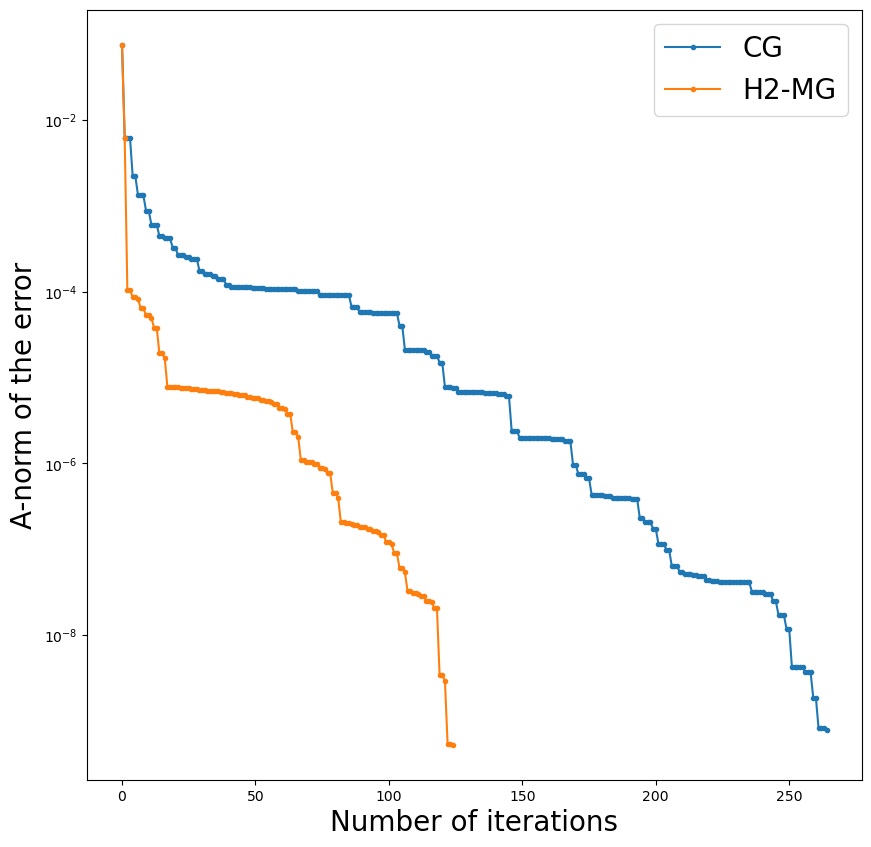

In [15]:
# Plot the results:
def plot_data(data_cg, data_h2mg, time_or_iter = 'iter'):
    """
    Plots the received data, either per time or per iteration.
    """
    fig, axs = plt.subplots(1, 1, sharey=False, figsize=(10, 10))            
    marker='.'
    
    if time_or_iter == 'iter':
        axs.plot(data_cg[2], label='CG', marker=marker)
        axs.plot(data_h2mg[2], label='H2-MG', marker=marker)
    else:
        axs.plot(data_cg[3], data[cf][2], label='CG', marker=marker)
        axs.plot(data_h2mg[3], data[cf][2], label='H2-MG', marker=marker)
    axs.set_yscale('log')
    axs.set_ylabel('A-norm of the error', fontsize=20)
    axs.legend(fontsize=20)
    if time_or_iter == 'iter':
        axs.set_xlabel('Number of iterations', fontsize=20)
    else: 
        axs.set_xlabel('Time, sec', fontsize=20)
plot_data(data_cg, data_h2mg, time_or_iter = 'iter')